# Notebook de modelagem

## 0.General imports

In [1]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler,StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.stat import Correlation
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler


## 1.Reading processed data

In [2]:
offers_base_df = pd.read_parquet("../data/processed/offers_base_clean.parquet")


In [3]:
offers_base_df

,account_id,offer_id_cleaned,completed,age,credit_card_limit,gender,registered_on,registered_on_date,account_age_months,age_group,discount_value,duration,min_value,offer_type,has_web,has_email,has_mobile,has_social,is_credit_limit_null,is_age_null
0,0861b9ca31b741bb8b411b18f82d18f6,f19421c1d4aa40978ebb69ca19b0e20d,1,73,92000.0,M,20170627,2017-06-27,13.000000,66+,5,5.0,5,bogo,1,1,1,1,0,0
1,0485b8cb0bfc4d938895bbd6d8cbd7df,2906b810c7d4411798c6938adc9daaa5,0,0,0.0,unknown,20180325,2018-03-25,4.064516,unknown,2,7.0,10,discount,1,1,1,0,0,0
2,e0f1ca131f4b40a7a5f232b11efa4aea,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0,0.0,unknown,20170127,2017-01-27,18.000000,unknown,3,7.0,7,discount,1,1,1,1,0,0
3,4ecbfa77f6f84e779ea318682295cbdb,3f207df678b143eea3cee63160fa8bed,0,83,58000.0,F,20130924,2013-09-24,58.096774,66+,0,4.0,0,informational,1,1,1,0,0,0
4,523e2d85f3d94eefbca7970e2b16b234,4d5c57ea9a6940dd891ad53e9dbe8da0,1,47,65000.0,F,20160609,2016-06-09,25.580645,46-55,10,5.0,10,bogo,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,98acc5bdb36144b88c2ff68e0ec95d54,5a8bc65990b245e5a138643cd4eb9837,0,42,33000.0,M,20171130,2017-11-30,7.903226,36-45,0,3.0,0,informational,0,1,1,1,0,0
76273,3f3494f3234e4206a279662bef81fe85,4d5c57ea9a6940dd891ad53e9dbe8da0,0,61,60000.0,F,20140715,2014-07-15,48.387097,56-65,10,5.0,10,bogo,1,1,1,1,0,0
76274,77caa79f70754278b0b1fdd68e7796b9,2906b810c7d4411798c6938adc9daaa5,0,44,69000.0,M,20171025,2017-10-25,9.064516,36-45,2,7.0,10,discount,1,1,1,0,0,0
76275,f17d13f232ad4eaa973185c5a07d991d,2298d6c36e964ae4a3e7e9706d1fb8c2,0,26,60000.0,M,20180209,2018-02-09,5.580645,26-35,3,7.0,7,discount,1,1,1,1,0,0


In [4]:
offers_base_df.columns

Index(['account_id', 'offer_id_cleaned', 'completed', 'age',
       'credit_card_limit', 'gender', 'registered_on', 'registered_on_date',
       'account_age_months', 'age_group', 'discount_value', 'duration',
       'min_value', 'offer_type', 'has_web', 'has_email', 'has_mobile',
       'has_social', 'is_credit_limit_null', 'is_age_null'],
      dtype='object')

## 2. Preparando a base e treinando uma regressão logística

One-hot encodding das variáveis categóricas

In [10]:
#One-hot encodding das variáveis categóricas

offers_base_encoded = pd.get_dummies(
    offers_base_df, 
    columns=["gender", "age_group", "offer_type"],
    drop_first=True)


In [28]:

# Separar features e target
X = offers_base_encoded.drop(columns=[
    "completed", 
    "account_id", 
    "offer_id_cleaned", 
    "registered_on", 
    "registered_on_date",
    "duration"
])
y = offers_base_encoded["completed"]



In [29]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamanho treino: {X_train.shape}")
print(f"Tamanho teste: {X_test.shape}")

Tamanho treino: (61021, 22)
Tamanho teste: (15256, 22)


Escalando as variáveis numéricas

In [30]:
# Lista das variáveis contínuas que vou escalar
cont_vars = ['age', 'account_age_months', 'discount_value',  'min_value']
# 'duration',

scaler = StandardScaler()

X_train[cont_vars] = scaler.fit_transform(X_train[cont_vars])

X_test[cont_vars] = scaler.transform(X_test[cont_vars])

Vou treinar agora uma regressão logística

In [31]:
from sklearn.linear_model import LogisticRegression

# Criar o modelo de Regressão Logística
model = LogisticRegression(max_iter=200, solver='lbfgs', random_state=42)

# Treinar o modelo
model.fit(X_train, y_train)

/Users/giovannaisolani/Documents/ifood-case/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, random_state=42)

## 3. Avaliação dos resultados

In [32]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Avaliações
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"AUC ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")

Accuracy: 0.7733
Precision: 0.7402
Recall: 0.8145
AUC ROC: 0.8559


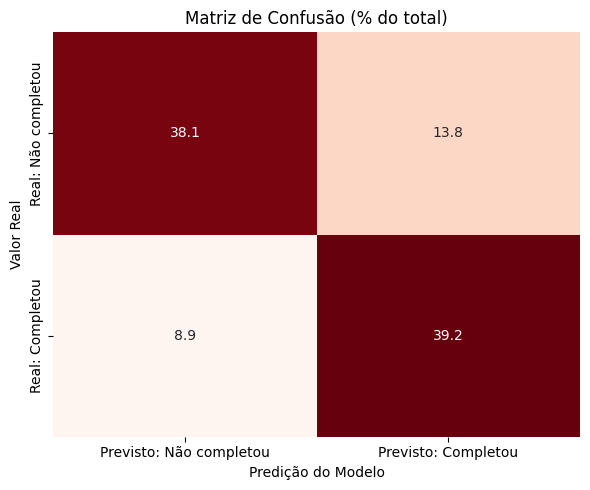

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum() * 100  # percentual sobre o total

# Criar um heatmap com seaborn apenas com percentuais
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Reds", cbar=False,
            xticklabels=["Previsto: Não completou", "Previsto: Completou"],
            yticklabels=["Real: Não completou", "Real: Completou"])

plt.title("Matriz de Confusão (% do total)")
plt.xlabel("Predição do Modelo")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()

/var/folders/2g/b4m3p_r5305gp9vx98yvdrg40000gn/T/ipykernel_15972/2826021501.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df_plot.groupby("bin").agg(
/var/folders/2g/b4m3p_r5305gp9vx98yvdrg40000gn/T/ipykernel_15972/2826021501.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(bin_summary["bin"].astype(str), rotation=45)


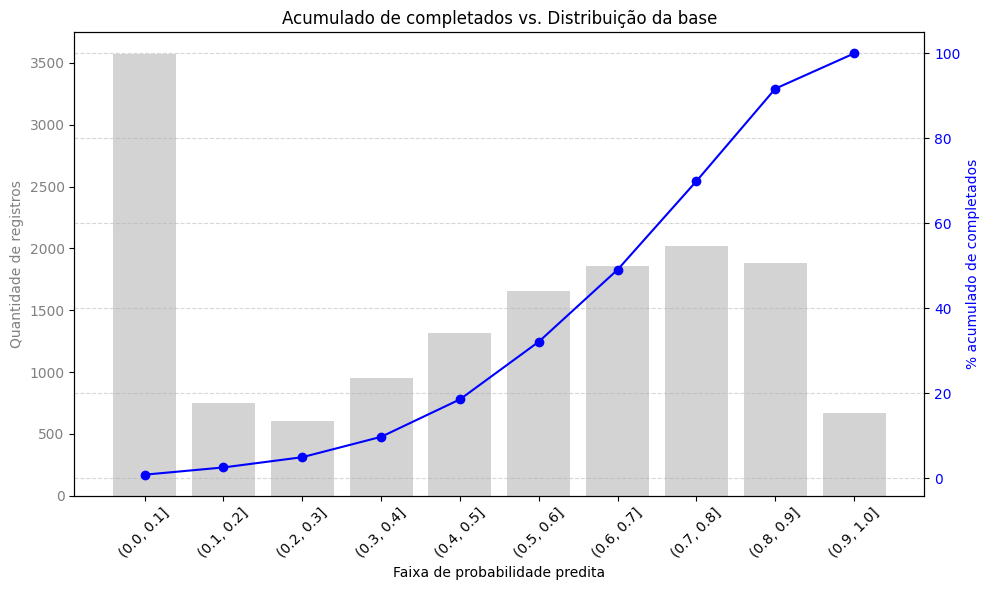

In [44]:
df_plot = pd.DataFrame({
    "proba": y_pred_proba,
    "completed": y_test
})

df_plot["bin"] = pd.cut(df_plot["proba"], bins=np.linspace(0, 1, 11))

# Total de registros e total de completados por faixa
bin_summary = df_plot.groupby("bin").agg(
    total=("completed", "count"),
    completed=("completed", "sum")
).reset_index()

# Percentuais acumulados
bin_summary["completed_cumsum"] = bin_summary["completed"].cumsum()
bin_summary["completed_cum_pct"] = bin_summary["completed_cumsum"] / bin_summary["completed"].sum() * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(bin_summary["bin"].astype(str), bin_summary["total"], color="lightgray", label="Total por faixa")
ax1.set_ylabel("Quantidade de registros", color="gray")
ax1.tick_params(axis='y', labelcolor="gray")
ax1.set_xlabel("Faixa de probabilidade predita")
ax1.set_xticklabels(bin_summary["bin"].astype(str), rotation=45)

ax2 = ax1.twinx()

# Gráfico de linha (acumulado de completados)
ax2.plot(bin_summary["bin"].astype(str), bin_summary["completed_cum_pct"], color="blue", marker="o", label="% acumulado de completados")
ax2.set_ylabel("% acumulado de completados", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

plt.title("Acumulado de completados vs. Distribuição da base")
fig.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Percentual de registros por faixa do modelo:

In [48]:
df_pct = pd.DataFrame({
    "proba": y_pred_proba,
    "completed": y_test
})

df_pct["bin"] = pd.cut(df_pct["proba"], bins=np.linspace(0, 1, 11))  # 10 faixas

bin_summary = df_pct.groupby("bin").agg(
    qtd_total=("completed", "count"),
    qtd_completados=("completed", "sum")
).reset_index()

total_completados = df_pct["completed"].sum()
bin_summary["pct_total"] = bin_summary["qtd_total"] / bin_summary["qtd_total"].sum() * 100
bin_summary["pct_completados_na_faixa"] = bin_summary["qtd_completados"] / bin_summary["qtd_total"] * 100
bin_summary["pct_completados_do_total"] = bin_summary["qtd_completados"] / total_completados * 100

bin_summary.columns = [
    "Faixa de Probabilidade",
    "Quantidade Total",
    "Completados (target=1)",
    "Percentual do Total (%)",
    "Percentual com target=1 (%)",
    "Percentual dos target=1 (%)"
]

bin_summary

/var/folders/2g/b4m3p_r5305gp9vx98yvdrg40000gn/T/ipykernel_15972/4172703097.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df_pct.groupby("bin").agg(


,Faixa de Probabilidade,Quantidade Total,Completados (target=1),Percentual do Total (%),Percentual com target=1 (%),Percentual dos target=1 (%)
0,"(0.0, 0.1]",3568,60,23.387520,1.681614,0.817661
1,"(0.1, 0.2]",746,125,4.889879,16.756032,1.703461
2,"(0.2, 0.3]",603,177,3.952543,29.353234,2.412101
3,"(0.3, 0.4]",950,352,6.227058,37.052632,4.796947
4,"(0.4, 0.5]",1314,647,8.613005,49.238965,8.817116
5,"(0.5, 0.6]",1652,996,10.828526,60.290557,13.573181
6,"(0.6, 0.7]",1855,1245,12.159150,67.115903,16.966476
7,"(0.7, 0.8]",2018,1530,13.227583,75.817641,20.850368
8,"(0.8, 0.9]",1884,1597,12.349240,84.766454,21.763423
9,"(0.9, 1.0]",666,609,4.365496,91.441441,8.299264


/var/folders/2g/b4m3p_r5305gp9vx98yvdrg40000gn/T/ipykernel_15972/260128208.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = results.groupby("bin").agg(


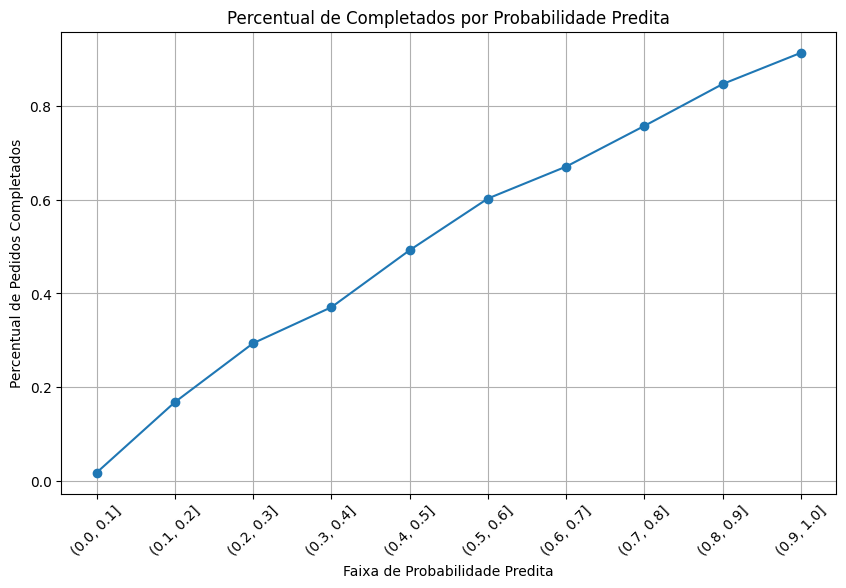

In [34]:
results = pd.DataFrame({
    "probabilidade": y_pred_proba,
    "real": y_test
})

results["bin"] = pd.cut(results["probabilidade"], bins=np.linspace(0, 1, 11))  

# Taxa de completados por faixa
bin_summary = results.groupby("bin").agg(
    completados=("real", "mean"),
    quantidade=("real", "count")
).reset_index()

plt.figure(figsize=(10,6))
plt.plot(bin_summary["bin"].astype(str), bin_summary["completados"], marker='o')
plt.xticks(rotation=45)
plt.xlabel("Faixa de Probabilidade Predita")
plt.ylabel("Percentual de Pedidos Completados")
plt.title("Percentual de Completados por Probabilidade Predita")
plt.grid(True)
plt.show()

Curva ROC

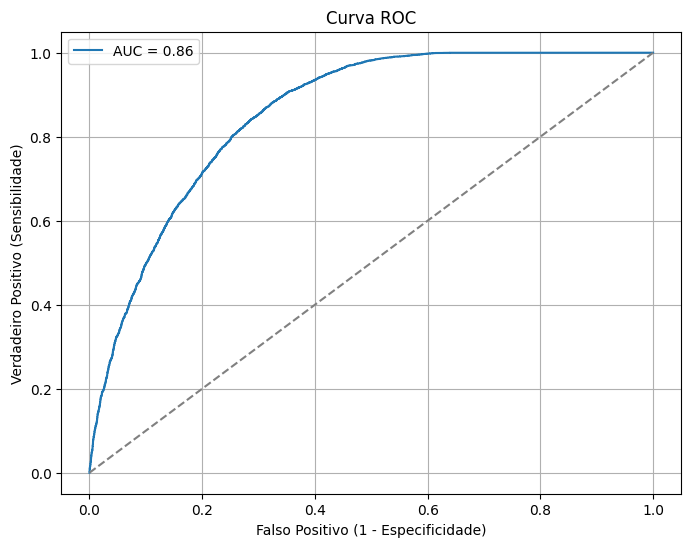

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Falso Positivo (1 - Especificidade)")
plt.ylabel("Verdadeiro Positivo (Sensibilidade)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
import pandas as pd

coeficientes_modelo = pd.DataFrame({
    "Feature": X_train.columns,
    "Coeficiente": model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

coeficientes_modelo

,Feature,Coeficiente
20,offer_type_discount,1.241787
5,has_web,0.924252
7,has_mobile,0.535275
2,account_age_months,0.457022
3,discount_value,0.342253
8,has_social,0.215884
0,age,0.207136
15,age_group_36-45,0.135481
12,gender_O,0.012852
14,age_group_26-35,0.003256


Utilizando o stats model para ajustar o modelo e obter os p-valores

In [54]:
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns
print("Colunas não numéricas:", non_numeric_cols.tolist())

Colunas não numéricas: ['gender_M', 'gender_O', 'gender_unknown', 'age_group_26-35', 'age_group_36-45', 'age_group_46-55', 'age_group_56-65', 'age_group_66+', 'age_group_unknown', 'offer_type_discount', 'offer_type_informational']


In [55]:
X_train_clean = X_train.copy()
for col in non_numeric_cols:
    if X_train_clean[col].dropna().isin([True, False]).all():
        X_train_clean[col] = X_train_clean[col].astype(int)
    else:
        print(f"Atenção: Coluna '{col}' não é numérica nem booleana. Verifique se deve ser tratada.")



In [59]:
# Verificando variáveis que tem apenas um valor preenchido
constant_cols = [col for col in X_train_clean.columns if X_train_clean[col].nunique() == 1]
print("Colunas constantes:", constant_cols)

Colunas constantes: ['has_email', 'is_credit_limit_null', 'is_age_null']


In [60]:
corr_matrix = X_train_clean.corr()
perfect_corr = (corr_matrix == 1.0).sum()
print("Colunas com correlação 1.0:", perfect_corr[perfect_corr > 1])

Colunas com correlação 1.0: gender_unknown       2
age_group_unknown    2
dtype: int64


In [61]:
X_train_clean = X_train_clean.drop(columns=constant_cols)
X_train_clean = X_train_clean.drop(columns=['gender_unknown'])


In [62]:
X_train_const = sm.add_constant(X_train_clean)
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()
print(result.summary())

         Current function value: 0.438115
         Iterations: 35


/Users/giovannaisolani/Documents/ifood-case/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:              completed   No. Observations:                61021
Model:                          Logit   Df Residuals:                    61002
Method:                           MLE   Df Model:                           18
Date:                Thu, 01 May 2025   Pseudo R-squ.:                  0.3662
Time:                        14:21:45   Log-Likelihood:                -26734.
converged:                      False   LL-Null:                       -42184.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0467      0.124     -0.377      0.706      -0.289       0.196
age                          0.1448      0.059      2.461      0.014       0.029       0.